# Import libraries

In [1]:
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.manifold import TSNE

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)

In [3]:
path_to_save = './../results/02c_dim_reduction'

# Loading data

## Train data (*smoothed & scaled*)

In [4]:
path_to_ftir_data = './../data/preprocessed_data/ftir_scaled_train.csv'

In [5]:
data = pd.read_csv(path_to_ftir_data, index_col=0)

print(data.shape)
data.head(3)

(26, 1142)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141
wavenumber,1900.766600,1899.802230,1898.837870,1897.873500,1896.909130,1895.944770,1894.980400,1894.016030,1893.051670,1892.087300,1891.122930,1890.158570,1889.194200,1888.229830,1887.265470,1886.301100,1885.336730,1884.372370,1883.408000,1882.44364,1881.479270,1880.514900,1879.550540,1878.586170,1877.621800,...,823.569090,822.604720,821.640360,820.675990,819.711620,818.747260,817.782890,816.818520,815.854160,814.889790,813.925420,812.961060,811.996690,811.032320,810.067960,809.103590,808.139230,807.174860,806.210490,805.246130,804.281760,803.317390,802.353030,801.388660,800.424290
1,0.000494,0.000944,0.001362,0.001750,0.002112,0.002451,0.002770,0.003074,0.003364,0.003646,0.003921,0.004193,0.004467,0.004744,0.005028,0.005324,0.005633,0.005960,0.006308,0.00668,0.007079,0.007509,0.007974,0.008476,0.009019,...,0.037121,0.035323,0.033560,0.031835,0.030152,0.028514,0.026926,0.025390,0.023910,0.022491,0.021135,0.019846,0.018627,0.017483,0.016417,0.015433,0.014533,0.013723,0.013004,0.012382,0.011859,0.011440,0.011127,0.010924,0.010836
2,0.000210,0.000215,0.000213,0.000205,0.000192,0.000175,0.000155,0.000132,0.000109,0.000085,0.000063,0.000042,0.000025,0.000011,0.000003,0.000000,0.000004,0.000017,0.000039,0.00007,0.000113,0.000168,0.000236,0.000318,0.000415,...,0.072690,0.071565,0.070364,0.069083,0.067721,0.066275,0.064743,0.063123,0.061413,0.059610,0.057713,0.055719,0.053626,0.051432,0.049135,0.046732,0.044221,0.041600,0.038868,0.036021,0.033058,0.029976,0.026773,0.023447,0.019997


## Samples description

In [6]:
path_to_samples_description = './../data/preprocessed_data/ftir_description.csv'

In [7]:
samples_description = pd.read_csv(path_to_samples_description, index_col=0)

samples_description.index = samples_description.index.astype(str)

print(samples_description.shape)
samples_description.head(3)

(29, 4)


,Description,Type,Class,Label
1,"MFGO, разб. 1:20",$GO$,1,Train
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1,Train
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1,Train


# Datasets wrangling

## FTIR data

In [8]:
data = data.loc['1':]

print(data.shape)
data.head(3)

(25, 1142)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141
1,0.000494,0.000944,0.001362,0.001750,0.002112,0.002451,0.002770,0.003074,0.003364,0.003646,0.003921,0.004193,0.004467,0.004744,0.005028,0.005324,0.005633,0.005960,0.006308,0.006680,0.007079,0.007509,0.007974,0.008476,0.009019,...,0.037121,0.035323,0.033560,0.031835,0.030152,0.028514,0.026926,0.025390,0.023910,0.022491,0.021135,0.019846,0.018627,0.017483,0.016417,0.015433,0.014533,0.013723,0.013004,0.012382,0.011859,0.011440,0.011127,0.010924,0.010836
2,0.000210,0.000215,0.000213,0.000205,0.000192,0.000175,0.000155,0.000132,0.000109,0.000085,0.000063,0.000042,0.000025,0.000011,0.000003,0.000000,0.000004,0.000017,0.000039,0.000070,0.000113,0.000168,0.000236,0.000318,0.000415,...,0.072690,0.071565,0.070364,0.069083,0.067721,0.066275,0.064743,0.063123,0.061413,0.059610,0.057713,0.055719,0.053626,0.051432,0.049135,0.046732,0.044221,0.041600,0.038868,0.036021,0.033058,0.029976,0.026773,0.023447,0.019997
3,0.002533,0.002476,0.002405,0.002323,0.002230,0.002128,0.002017,0.001899,0.001776,0.001648,0.001517,0.001383,0.001250,0.001116,0.000985,0.000856,0.000732,0.000613,0.000501,0.000397,0.000303,0.000218,0.000146,0.000087,0.000042,...,0.208237,0.205610,0.203011,0.200442,0.197910,0.195416,0.192967,0.190564,0.188213,0.185918,0.183681,0.181509,0.179403,0.177369,0.175410,0.173531,0.171735,0.170026,0.168408,0.166886,0.165463,0.164143,0.162931,0.161829,0.160843


## Samples descriprion

In [9]:
samples_description = samples_description.loc[samples_description['Label'] == 'Train']

print(samples_description.shape)
samples_description.head(3)

(25, 4)


,Description,Type,Class,Label
1,"MFGO, разб. 1:20",$GO$,1,Train
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1,Train
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1,Train


## Additional correction of column `Type`

In [10]:
type_dict = {
    '$rGO$': '$вОГ$',
    '$GO$': '$ОГ$',
    '$GO_{d}$': '$ОГ_{диализ}$',
}

samples_description['Type'] = samples_description['Type'].apply(lambda x: type_dict[x])

print(samples_description.shape)
samples_description.head(3)

(25, 4)


,Description,Type,Class,Label
1,"MFGO, разб. 1:20",$ОГ$,1,Train
2,"HGO, 0.0116 г в 25 мл H2O",$ОГ$,1,Train
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$ОГ$,1,Train


# Analysis of lower dimensional data

## Class for dimensionality reduction

In [11]:
class DimensionalityReduction:
    def __init__(self, data, hue=None):
        self.data = data
        self.hue = hue if hue is not None else None
        self.results = {}

    def _apply_method(self, method, name, target=None, *args, **kwargs):
        model = method(*args, **kwargs)
        transformed_data = model.fit_transform(self.data, target) if target is not None else model.fit_transform(self.data)

        columns = [f'ax_{i}' for i in range(1, transformed_data.shape[1] + 1)]
        self.results[name] = pd.DataFrame(transformed_data, columns=columns)

        if hasattr(model, 'explained_variance_ratio_'):
            self.results[f'{name}_variance'] = [round(k, 4) for k in model.explained_variance_ratio_]

    def get_pca(self, n_components=2, random_state=42):
        self._apply_method(PCA, 'pca', n_components=n_components, random_state=random_state)

    def get_lda(self, target, n_components=2):
        self._apply_method(LinearDiscriminantAnalysis, 'lda', target=target, n_components=n_components, solver='svd')

    def get_nmf(self, n_components=2, random_state=42):
        self._apply_method(NMF, 'nmf', n_components=n_components, init='nndsvd', max_iter=100_000, random_state=random_state)

    def get_tsne(self, n_components=2, learning_rate=10, init='pca', perplexity=5, n_iter=10_000, random_state=42):
        self._apply_method(TSNE, 'tsne', n_components=n_components, learning_rate=learning_rate,
                           init=init, perplexity=perplexity, n_iter=n_iter, random_state=random_state)

    def get_visualization(self, method='pca', ax=None, figsize=(8, 6), palette='Dark2', markersize=14,
                          fontstyle='normal', fontsize=14, path_to_save=None, dpi=300, title=True):
        if method not in self.results:
            raise ValueError(f"Метод {method} не был применен. Сначала вызовите get_{method}.")
        
        data = self.results[method]
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
        
        sns.scatterplot(
            data=data,
            x=data.columns[0],
            y=data.columns[1],
            hue=self.hue,
            palette=palette,
            s=markersize,
            ax=ax
        )
        
        # xlabel = f'Ось 1' if method != 'pca' else f'Главная компонента 1\n ($PoEV$ = {self.results.get("pca_variance", [None, None])[0]})'
        # ylabel = f'Ось 2' if method != 'pca' else f'Главная компонента 2\n ($PoEV$ = {self.results.get("pca_variance", [None, None])[1]})'

        xlabel = f'Axis 1' if method != 'pca' else f'Principal component 1\n ($PoEV$ = {self.results.get("pca_variance", [None, None])[0]})'
        ylabel = f'Axis 2' if method != 'pca' else f'Principal component 2\n ($PoEV$ = {self.results.get("pca_variance", [None, None])[1]})'
        
        ax.set_xlabel(xlabel, fontstyle=fontstyle, fontsize=fontsize, labelpad=5)
        ax.set_ylabel(ylabel, fontstyle=fontstyle, fontsize=fontsize, labelpad=5)

        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
        
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize-2)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize-2)

        if title:
            method_titles = {
                'pca': rf'$\mathbf{{(A)}}$ Метод главных компонент  ($PCA$)',
                'lda': rf'$\mathbf{{(B)}}$ Линейный дискриминантный анализ ($LDA$)',
                'nmf': rf'$\mathbf{{(C)}}$ Факторизация неотрицательной матрицы ($NMF$)',
                'tsne': rf'$\mathbf{{(D)}}$ $t$-распределённое стохастическое' + f'\nвложение соседей ($t-SNE$)'
            }

            # method_titles = {
            #     'pca': rf'$\mathbf{{(B)}}$ Principal Component Analysis ($PCA$)',
            #     'lda': rf'$\mathbf{{(C)}}$ Linear Discriminant Analysis ($LDA$)',
            #     'nmf': rf'$\mathbf{{(D)}}$ Non-Negative Matrix Factorization ($NMF$)',
            #     'tsne': rf'$\mathbf{{(E)}}$ t-distributed Stochastic Neighbor' + '\nEmbedding ($t-SNE$)'
            # }
            
            ax.set_title(method_titles.get(method, method.upper()), fontstyle='normal', fontsize=fontsize, fontweight='bold', pad=10)

        ax.legend(loc='best', fontsize=fontsize-2, markerscale=0.7)

        if ax is None:
            plt.tight_layout()
            
            if path_to_save:
                plt.savefig(path_to_save, dpi=600)
                
            plt.show()

    def get_combined_visualization(self, figsize=(16, 12), palette='Dark2', markersize=14, fontstyle='normal',
                                   fontsize=14, path_to_save=None, dpi=300):
        methods = ['pca', 'lda', 'nmf', 'tsne']

        fig, axes = plt.subplots(2, 2, figsize=figsize, dpi=dpi)
        axes = axes.flatten()

        sns.set_theme()

        for i, method in enumerate(methods):
            if method not in self.results:
                raise ValueError(f"Метод {method} не был применен. Сначала вызовите get_{method}.")
            self.get_visualization(method=method, ax=axes[i], palette=palette, markersize=markersize, fontsize=fontsize, title=True)

        plt.tight_layout()

        if path_to_save:
            plt.savefig(path_to_save, dpi=600)

        plt.show()

## Setting parameters for visualization

In [12]:
hue = samples_description['Type'].tolist()
target = samples_description['Class']

In [13]:
type_color_dict = {
    '$ОГ$': 'RoyalBlue',
    '$GO$': 'RoyalBlue',
    '$вОГ$': 'Goldenrod',
    '$rGO$': 'Goldenrod',
    '$ОГ_{диализ}$': 'SeaGreen',
    '$GO_{d}$': 'SeaGreen'
}

figsize = (17, 11.6)
markersize = 700 # 1024

fontsize = 20

## Visualization of the results of each method

In [14]:
dimred = DimensionalityReduction(data=data, hue=hue)

dimred.get_pca(n_components=2, random_state=42)
dimred.get_lda(target=target, n_components=2)
dimred.get_nmf(n_components=2, random_state=42)
dimred.get_tsne(n_components=2, perplexity=4, random_state=42)

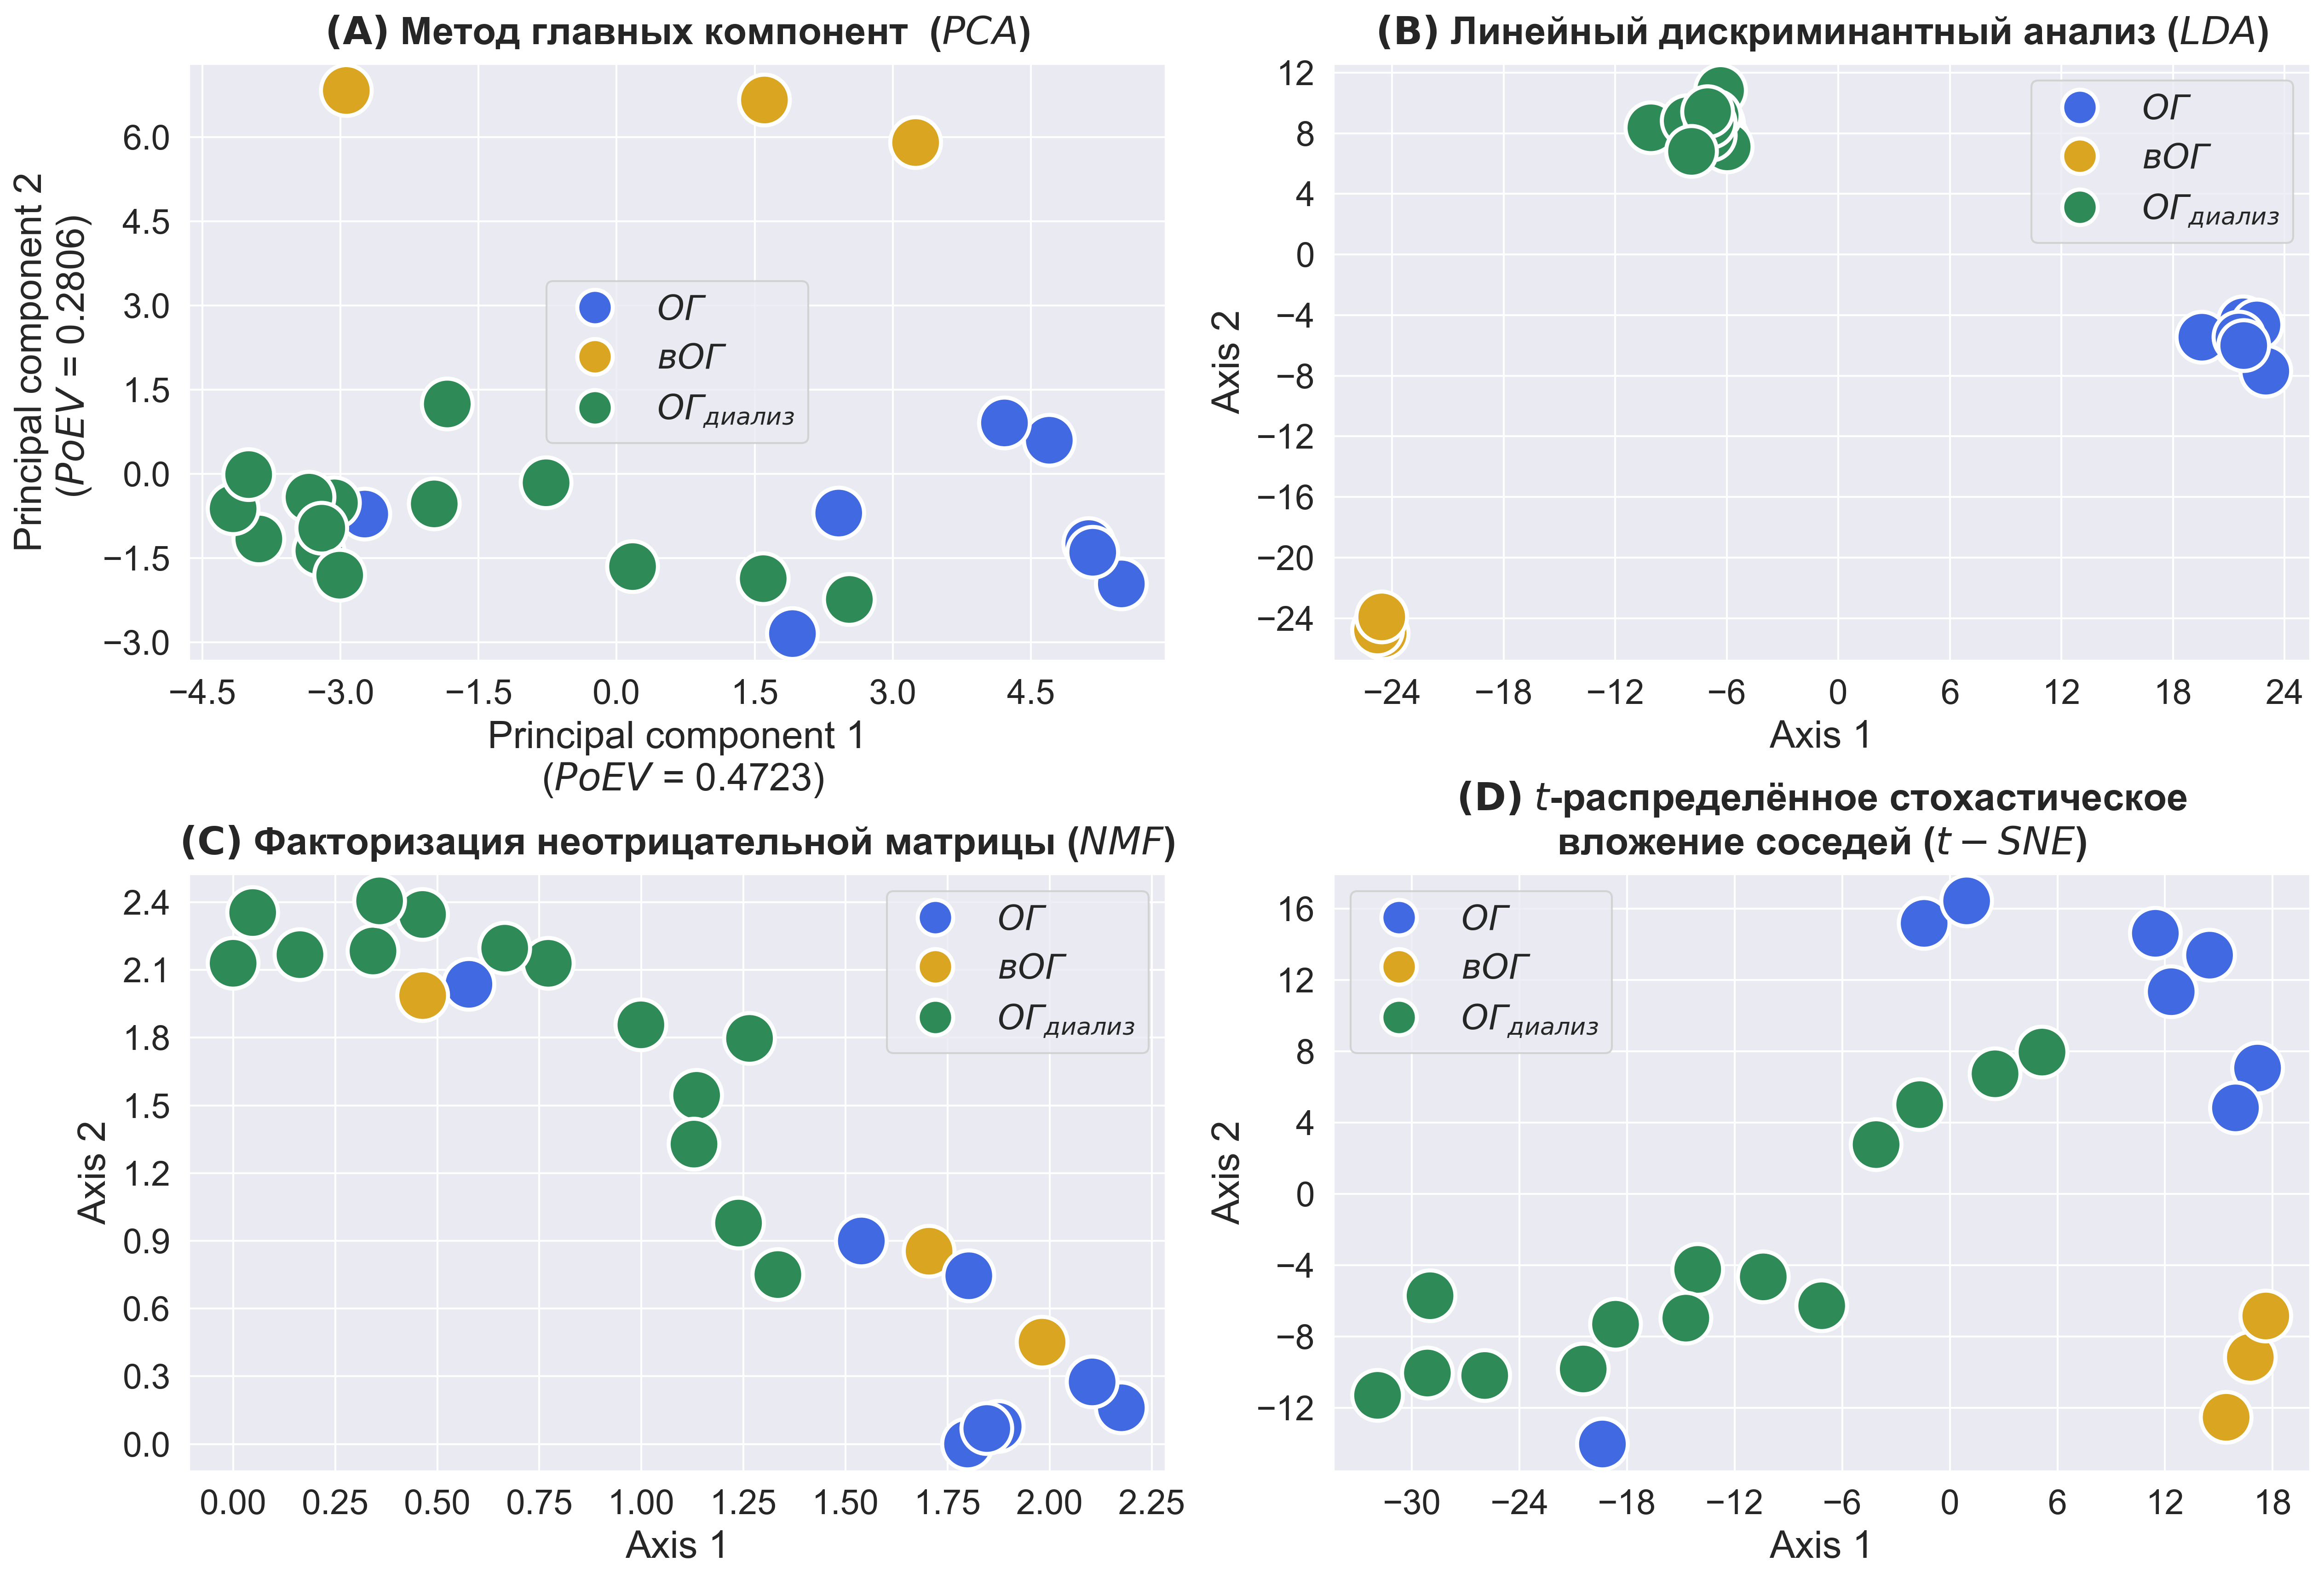

In [15]:
sns.set_theme()

dimred.get_combined_visualization(
    figsize=figsize,
    palette=type_color_dict,
    markersize=markersize,
    fontsize=fontsize,
    path_to_save=f'{path_to_save}/dimred_4_subplots.png'
)

## Additional example of applying PCA

In [16]:
# dimred = DimensionalityReduction(data=data, hue=hue)

# dimred.get_pca(n_components=2, random_state=42)
# dimred.get_visualization(method='pca', figsize=figsize, palette=type_color_dict, markersize=markersize, fontsize=fontsize,
#                          # path_to_save=f'{path_to_save}/pca.png'
#                         )